In [1]:
!pip -V

pip 23.3.1 from /opt/conda/lib/python3.10/site-packages/pip (python 3.10)


In [6]:
!pip list | grep clip

clip                      1.0


In [ ]:
# !pip install git+https://github.com/mhamilton723/FeatUp.git

# .init

In [2]:
import torch
import torchvision.transforms as T
from PIL import Image

from featup.util import norm, unnorm
from featup.plotting import plot_feats, plot_lang_heatmaps

## Dino v2 upsampler

In [6]:
import matplotlib.pyplot as plt
from featup.util import pca, remove_axes
from featup.featurizers.maskclip.clip import tokenize
from pytorch_lightning import seed_everything
import torch
import torch.nn.functional as F


@torch.no_grad()
def plot_feats_pca(image, lr, hr, fit_pca = None):
    assert len(image.shape) == len(lr.shape) == len(hr.shape) == 3
    seed_everything(0)
    [lr_feats_pca, hr_feats_pca], fit_pca = pca([lr.unsqueeze(0), hr.unsqueeze(0)], fit_pca = fit_pca)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image.permute(1, 2, 0).detach().cpu())
    ax[0].set_title("Image")
    ax[1].imshow(lr_feats_pca[0].permute(1, 2, 0).detach().cpu())
    ax[1].set_title("Original Features")
    ax[2].imshow(hr_feats_pca[0].permute(1, 2, 0).detach().cpu())
    ax[2].set_title("Upsampled Features")
    remove_axes(ax)
    plt.show()
    return fit_pca


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

upsampler = torch.hub.load("mhamilton723/FeatUp",
                           'dinov2', use_norm=use_norm).to(device)

## Patch utils

In [ ]:
def extract_patch(image, x, y, width, height):
  """
  Extracts a patch from the given image.

  Args:
    image: The PIL Image object.
    x: The x-coordinate of the top-left corner of the patch.
    y: The y-coordinate of the top-left corner of the patch.
    width: The width of the patch.
    height: The height of the patch.

  Returns:
    The extracted patch as a PIL Image object.
  """
  patch = image.crop((x, y, x + width, y + height))
  return patch

import numpy as np
import cv2

def extract_patches_numpy(image, patch_size, step):
    """
    Извлекает патчи из изображения заданного размера и с заданным шагом.

    :param image: Исходное изображение (numpy array).
    :param patch_size: Размер патча (высота, ширина).
    :param step: Шаг (по вертикали и горизонтали).
    :return: Список патчей.
    """
    patches = []
    height, width = image.shape[:2]
    patch_height, patch_width = patch_size

    for y in range(0, height - patch_height + 1, step):
        for x in range(0, width - patch_width + 1, step):
            patch = image[y:y + patch_height, x:x + patch_width]
            patches.append(patch)

    return patches

# Image 

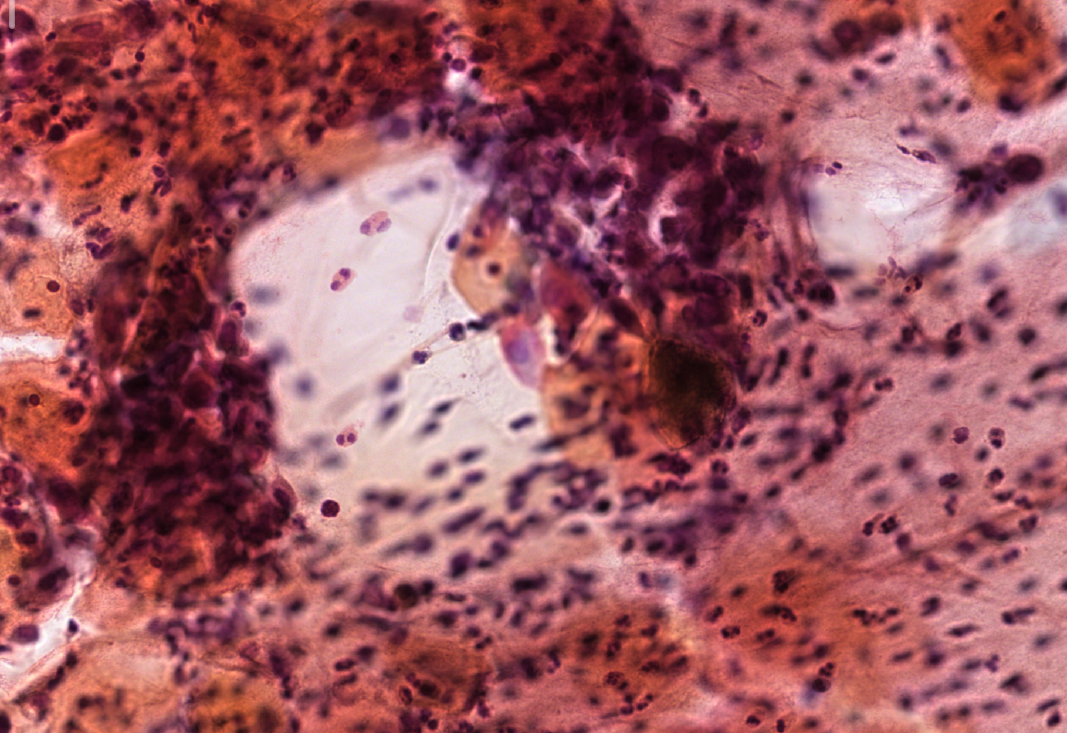

In [3]:
patch_size = 224
use_norm = True

transform = T.Compose([
    T.Resize(patch_size),
    T.CenterCrop((patch_size, patch_size)),
    T.ToTensor(),
    norm
])

image_path = '/root/feature-map-experiments/assets/c16-part1.png'
image = Image.open(image_path).convert("RGB")
image

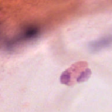

In [4]:


# image2 = extract_patch(image, 450, 550, 224, 224)
# image2 = extract_patch(image, 350, 100, 224, 224)
image2 = extract_patch(image, 300, 150, 112, 112)

image2

In [5]:
image_tensor = transform(image2).unsqueeze(0).to(device)

# DINO v2

/opt/conda/lib/python3.10/site-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/mhamilton723/FeatUp/zipball/main" to /root/.cache/torch/hub/main.zip
/opt/conda/lib/python3.10/site-packages/featup/featurizers/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/opt/conda/lib/python3.10/site-packages/featup/featurizers/

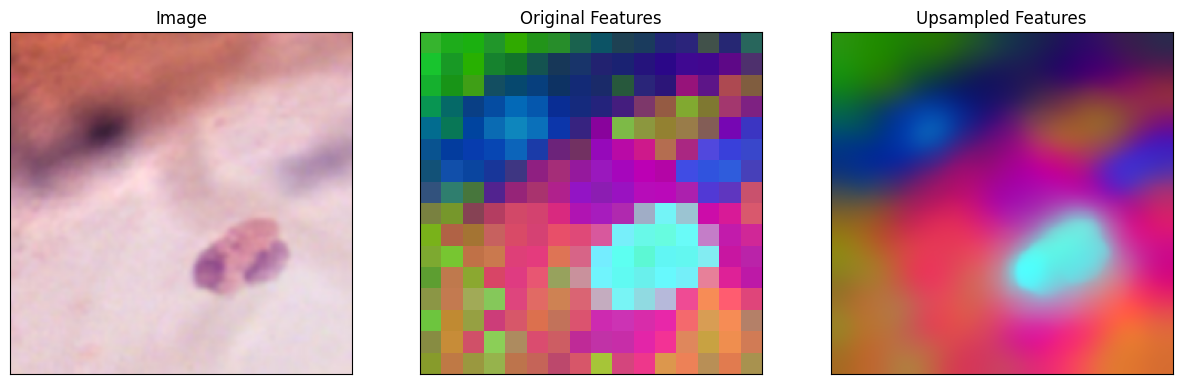

In [7]:

hr_feats = upsampler(image_tensor)
lr_feats = upsampler.model(image_tensor)
fit_pca = plot_feats_pca(unnorm(image_tensor)[0], lr_feats[0], hr_feats[0])

In [8]:
print(f'{hr_feats.shape=} {lr_feats.shape=}')

hr_feats.shape=torch.Size([1, 384, 256, 256]) lr_feats.shape=torch.Size([1, 384, 16, 16])


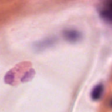

In [9]:
image3 = extract_patch(image, 300+56, 150, 112, 112)
image3

Seed set to 0


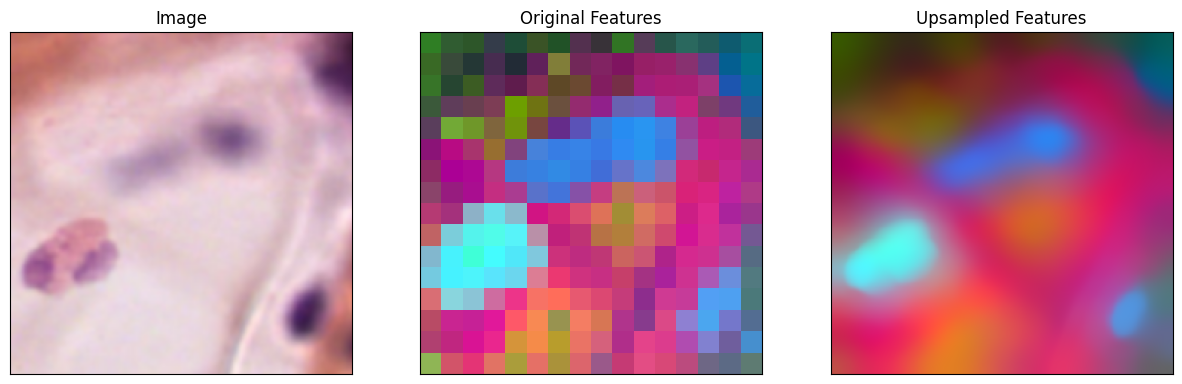

In [10]:
image_tensor2 = transform(image3).unsqueeze(0).to(device)

hr_feats = upsampler(image_tensor2)
lr_feats = upsampler.model(image_tensor2)
fit_pca = plot_feats_pca(unnorm(image_tensor2)[0], lr_feats[0], hr_feats[0], fit_pca=fit_pca)